In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm

import glob, os, yaml, subprocess, itertools, sparse, sys
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

eigenvec_df = pd.read_csv("../data/eigenvec_original_10PC.csv", index_col=[0])
#eigenvec_df = pd.read_csv("../data/eigenvec_100PC.csv", index_col=[0])
who_variants_combined = pd.read_csv("who_confidence_2021.csv")
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'

lineages = pd.read_csv("../data/combined_lineages_samples.csv", low_memory=False).query("sample_id in @eigenvec_df.index")
print(lineages.shape)
import collections, warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "utils"))
from stats_utils import *

coll2014 = pd.read_csv("../data/coll2014_SNP_scheme.tsv", sep="\t")
coll2014["#lineage"] = coll2014["#lineage"].str.replace("lineage", "")
coll2014.rename(columns={"#lineage": "Lineage"}, inplace=True)

drug_abbr_dict = {"Delamanid": "DLM",
                  "Bedaquiline": "BDQ",
                  "Clofazimine": "CFZ",
                  "Ethionamide": "ETH",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Capreomycin": "CAP",
                  "Amikacin": "AMI",
                  "Pretomanid": "PTM",
                  "Pyrazinamide": "PZA",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LEV",
                  "Streptomycin": "STM",
                  "Ethambutol": "EMB",
                  "Isoniazid": "INH",
                  "Rifampicin": "RIF"
                 }

(49113, 6)


In [2]:
single_lineages = lineages.query("~Coll2014.str.contains(',')")

# percent mixed lineage samples
print((len(lineages)-len(single_lineages)) / len(lineages))

# add primary lineage column
for i, row in single_lineages.iterrows():
    if row["Coll2014"][0].isnumeric():
        single_lineages.loc[i, "Lineage"] = row["Coll2014"][0]
    else:
        single_lineages.loc[i, "Lineage"] = row["Coll2014"]

0.010526744446480565


# 1. Numbers of R and S Isolates in each Model

In [ ]:
def compute_number_of_isolates_per_model(drug, phenos_name, tiers_lst):
    
    fName = os.path.join(analysis_dir, drug, "BINARY", f"tiers={'+'.join(tiers_lst)}/phenos={phenos_name}", "dropAF_noSyn_unpooled/model_matrix.pkl")
    
    if os.path.isfile(fName):
        model_matrix = pd.read_pickle(fName)

        samples = model_matrix.index.values
        del model_matrix

        df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv")).query("sample_id in @samples")    
        return len(df_phenos.query("phenotype==1")), len(df_phenos.query("phenotype==0"))
    else:
        return 0, 0

In [8]:
RS_counts_tier1 = pd.DataFrame(columns=["Drug", "WHO_Num_R", "WHO_Num_S", "ALL_Num_R", "ALL_Num_S"])

for i, drug in enumerate(np.sort(os.listdir(analysis_dir))):
    
    num_R_WHO, num_S_WHO = compute_number_of_isolates_per_model(drug, "WHO", ["1"])
    num_R_ALL, num_S_ALL = compute_number_of_isolates_per_model(drug, "ALL", ["1"])
    
    RS_counts_tier1.loc[i, :] = [drug, num_R_WHO, num_S_WHO, num_R_ALL, num_S_ALL]

In [9]:
# RS_counts_tier1.to_csv("/home/sak0914/RS_counts_tier1.csv", index=False)
RS_counts_tier1

,Drug,WHO_Num_R,WHO_Num_S,ALL_Num_R,ALL_Num_S
0,Amikacin,1108,7619,2429,21602
1,Bedaquiline,899,1262,1032,13081
2,Capreomycin,1299,8500,2024,15267
3,Clofazimine,213,4787,674,14181
4,Delamanid,51,514,246,11398
5,Ethambutol,6417,26112,9318,35284
6,Ethionamide,2161,3808,5129,15640
7,Isoniazid,13381,21433,20901,27725
8,Kanamycin,1589,6195,3492,20399
9,Levofloxacin,2735,9699,5871,21690


In [10]:
# counts are a little lower generally than tier 1 because there are more mutations across which there can be missingness, so more isolates were dropped
# RS_counts_tier12 = pd.DataFrame(columns=["Drug", "WHO_Num_R", "WHO_Num_S", "ALL_Num_R", "ALL_Num_S"])

# for i, drug in enumerate(np.sort(os.listdir(analysis_dir))):
    
#     num_R_WHO, num_S_WHO = compute_number_of_isolates_per_model(drug, "WHO", ["1", "2"])
#     num_R_ALL, num_S_ALL = compute_number_of_isolates_per_model(drug, "ALL", ["1", "2"])
    
#     RS_counts_tier12.loc[i, :] = [drug, num_R_WHO, num_S_WHO, num_R_ALL, num_S_ALL]

# 2. Lineage Counts per Drug Model

In [11]:
def create_lineage_summary_df(og_lineages_df, other_thresh=0.01):
    '''
    other_cols is a list of lineages that should be combined into an other category because there are so few of them. Basically just for aesthetic purposes
    '''
    
    lineage_summary = pd.DataFrame(og_lineages_df["Lineage"].value_counts())

    lineage_summary = lineage_summary.reset_index().rename(columns={"index":"Lineage", "Lineage": "Count"})
    
    # get lineages that are present at < 1% frequency. Combine them into an "Other" category for aesthetic purposes in plotting
    samples_total = lineage_summary["Count"].sum()
    samples_thresh = int(other_thresh*samples_total)
    other_cols = lineage_summary.query("Count < @samples_thresh")["Lineage"].values
    
    # ",".join(other_cols) --> this makes the name too long, but can try later
    # combine low-frequency lineages into an Other category
    lineage_summary = pd.concat([lineage_summary, 
                                 pd.DataFrame({"Lineage": "Other", "Count": lineage_summary.query("Lineage in @other_cols")["Count"].sum()
                                              }, index=[-1])
                                ]).query("Lineage not in @other_cols")
    
    lineage_summary = lineage_summary.sort_values("Lineage", ascending=True).reset_index(drop=True)
    lineage_summary["Count"] = lineage_summary["Count"].astype(int)
    return lineage_summary

In [12]:
create_lineage_summary_df(single_lineages)

,Lineage,Count
0,1,4062
1,2,15829
2,3,5621
3,4,22730
4,Other,354


In [24]:
def compute_number_of_lineages_per_model(drugs_lst, lineages_df):
    
    lineage_summaries_by_drug = []
    
    for drug in drugs_lst:
        
        # fName = os.path.join(analysis_dir, drug, "BINARY", f"tiers={'+'.join(tiers_lst)}/phenos={phenos_name}", "dropAF_noSyn_unpooled/model_matrix.pkl")
        fName = os.path.join(analysis_dir, drug, "phenos_binary.csv")

        if os.path.isfile(fName):
#             model_matrix = pd.read_pickle(fName)

#             samples = model_matrix.index.values
#             del model_matrix
            df_phenos = pd.read_csv(fName)
            samples = df_phenos["sample_id"].values
        
            single_drug_lineage_summary = create_lineage_summary_df(lineages_df.query("sample_id in @samples"), other_thresh=0.01)
            single_drug_lineage_summary["Drug"] = drug_abbr_dict[drug]

            lineage_summaries_by_drug.append(single_drug_lineage_summary)
        
    return pd.concat(lineage_summaries_by_drug, axis=0)

In [25]:
single_drug_lineage_summary = compute_number_of_lineages_per_model(os.listdir(analysis_dir), single_lineages)

In [26]:
# single_drug_lineage_summary.pivot(index="Drug", columns="Lineage", values="Count").to_csv("ALL_isolates_by_lineage.csv")

In [319]:
def create_stacked_percent_bar_chart(df, xvar, quantVar, hueVar, saveName=None):
    
    LinToColor_Dict = {"1": "#f381b2",
                       "2": "#006dbb",
                       "3": "#9f5eab",
                       "4": "#f6472b",
                       "5": "#76400e",
                       "Other": "white"
                      }
    
#     LinToColor_Dict = {"1": "#DF83AC",
#                    "2": "#7098CB",
#                    "3": "#815D9F",
#                    "4": "#E76956",
#                    "5": "#B67548",
#                    "6": "#6AB79E",
#                    "8": "#E4515B",
#                    "Other": "black"
#                       }
    
    # set the figure size
    fig, ax = plt.subplots(figsize=(12, 4))

    # # dataframe of total counts by lineage
    # total = df.groupby(xvar)[quantVar].sum().reset_index()

    lineage_stacked_for_plotting = single_drug_lineage_summary.pivot(index="Drug", columns="Lineage", values="Count")
    lineage_stacked_for_plotting["Total"] = lineage_stacked_for_plotting.sum(axis=1)

    # compute proportions for plotting
    for lineage in single_drug_lineage_summary["Lineage"].unique():
        lineage_stacked_for_plotting[lineage] = lineage_stacked_for_plotting[lineage] / lineage_stacked_for_plotting["Total"]
        
    del lineage_stacked_for_plotting["Total"]
    lineage_stacked_for_plotting = lineage_stacked_for_plotting.reset_index().melt(id_vars="Drug")
        
    # keep track of all the groups to increase the start value of the next bar
    prev_vals_array = np.zeros(len(lineage_stacked_for_plotting[xvar].unique()))
    
    # order in increasing lineage abundance for each drug
    lineage_stacked_for_plotting = lineage_stacked_for_plotting.sort_values(["Drug", "value"], ascending=[True, False])
    
    # iterate through the Lineages and convert to percentages
    color_groups = lineage_stacked_for_plotting[hueVar].unique()
    
    for i, color_group in enumerate(color_groups):        
                        
        # dataframe of proportion of each drug's samples that belong to the current lineage
        single_group = lineage_stacked_for_plotting[lineage_stacked_for_plotting[hueVar]==color_group].groupby(xvar)["value"].sum().reset_index()

        if i > 0:
            prev_vals = lineage_stacked_for_plotting[lineage_stacked_for_plotting[hueVar]==color_groups[i-1]].groupby(xvar)["value"].sum().reset_index()["value"].values 
            prev_vals_array += prev_vals
            
        ax.bar(single_group[xvar].values, 
               single_group["value"].values, 
               color=LinToColor_Dict[color_group], 
               bottom = prev_vals_array, 
               edgecolor="black",
               label=color_group,
              )
    
        # the other group is very tiny and not worth plotting
        if color_group != "Other":
            label_loc = 'center'
            annot_format = '{:.2f}'
            ax.bar_label(ax.containers[i], fmt=annot_format, label_type=label_loc, fontsize='9')
    
    plt.setp(ax.patches, linewidth=0.75)
    sns.despine()
    
    bar_scale = 0.85
    for patch in ax.patches:
        current_width = patch.get_width()
        patch.set_width(current_width * bar_scale)
    
    # Rearrange the handles and labels
    handles, labels = ax.get_legend_handles_labels()    
    handles_labels_dict = dict(zip(labels, handles))
    handles_labels_dict = collections.OrderedDict(sorted(handles_labels_dict.items()))

    # Create the legend with the rearranged handles and labels
    ax.legend(list(handles_labels_dict.values()), list(handles_labels_dict.keys()))
    sns.move_legend(ax, fontsize=8, title='Lineage', loc='upper right', #bbox_to_anchor=(1.05, 0.65),
                    ncol=len(color_groups),
                   bbox_to_anchor=(0.65, -0.1))

    if saveName is not None:
        plt.savefig(saveName, dpi=300, bbox_inches='tight')
    else:
        plt.show()

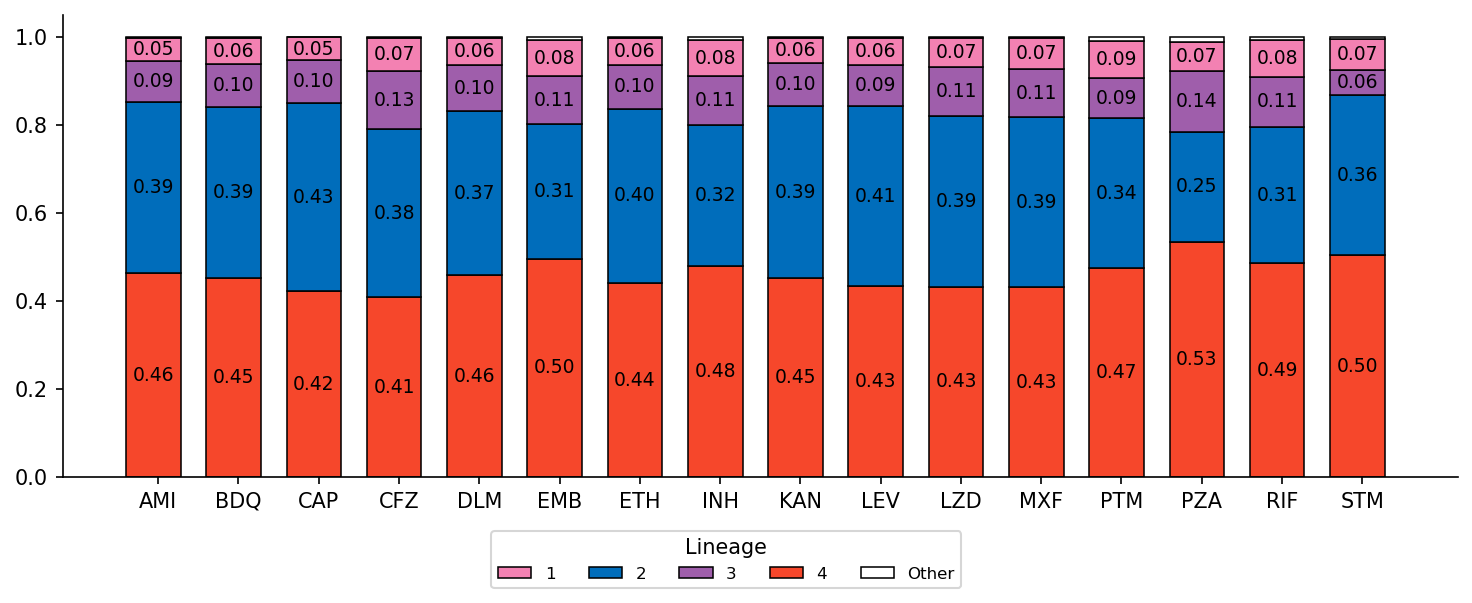

In [321]:
create_stacked_percent_bar_chart(single_drug_lineage_summary, "Drug", "Count", "Lineage", saveName="samples_by_lineage_stacked_bar.png")

In [174]:
def compute_mean_resistance_by_primary_lineage(drug, lineages_df, resist_mean_thresh=0.1):
    
    df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv"))
    
    # combine the lineages dataframe and the phenotypes dataframe for a single drug
    lineages_phenos_combined = lineages_df.merge(df_phenos, on="sample_id")
    # lineages_phenos_combined["L2"] = (lineages_phenos_combined["Lineage"] == "2").astype(int)

    R_summary = pd.DataFrame(lineages_phenos_combined.groupby("Lineage")["phenotype"].mean()).reset_index()

    # other_cols = L2_meanR_summary.query("phenotype < @resist_mean_thresh")["Lineage"].values
    # other_cols = ["BOV", "BOV_AFRI", "canetti"]
    
    # not enough data for L6 and L7. Don't show Bovis on here. L5 has a lot of 0 percent resistant, so doesn't appear a lot on the plot
    keep_cols = (np.arange(5) + 1).astype(str)
    R_summary = R_summary.query("Lineage in @keep_cols")

    R_summary = R_summary.sort_values("Lineage", ascending=True).reset_index(drop=True)
    R_summary["Drug"] = drug_abbr_dict[drug]
    
    # this column is just to help sort the barplot, just aesthetics
    R_summary["max_R_single_drug"] = np.max(R_summary["phenotype"])
    return R_summary

In [175]:
R_by_lineage = []

for drug in np.sort(os.listdir(analysis_dir)):
    
    R_by_lineage.append(compute_mean_resistance_by_primary_lineage(drug, single_lineages))
    
R_by_lineage = pd.concat(R_by_lineage, axis=0)
assert R_by_lineage["phenotype"].min() <= 1
assert R_by_lineage["phenotype"].max() <= 1
# R_by_lineage = R_by_lineage.pivot(index="Drug", columns="Lineage", values="phenotype")

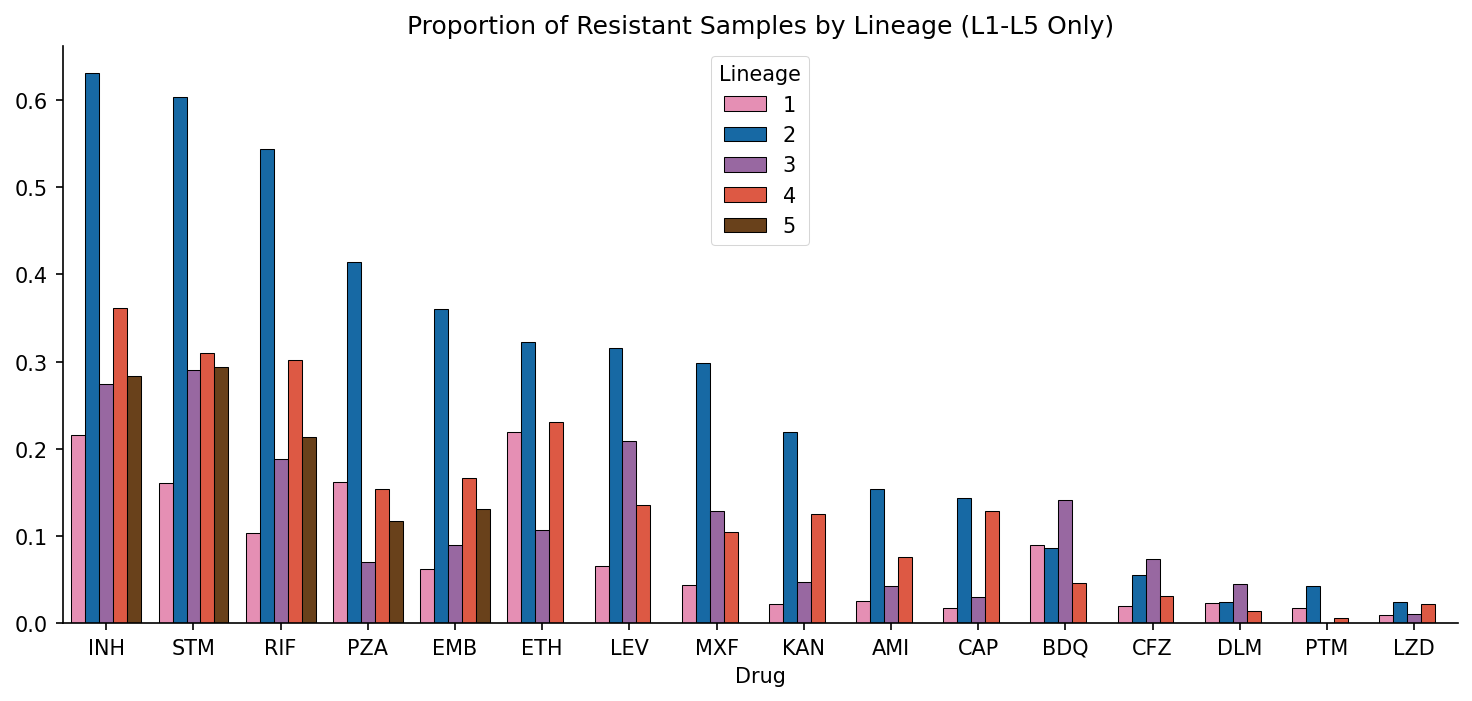

In [203]:
fig, ax = plt.subplots(figsize=(12, 5))

LinToColor_Dict = {"1": "#f381b2",
                   "2": "#006dbb",
                   "3": "#9f5eab",
                   "4": "#f6472b",
                   "5": "#76400e"
                  }

sns.barplot(data=R_by_lineage.sort_values(["max_R_single_drug", "Lineage"], ascending=[False, True]),
            x="Drug",
            y="phenotype",
            hue="Lineage",
            edgecolor="black",
            palette=LinToColor_Dict,
            ax=ax
           )

plt.setp(ax.patches, linewidth=0.5)
plt.legend(title="Lineage", loc="upper center")
plt.ylabel("")
plt.title("Proportion of Resistant Samples by Lineage (L1-L5 Only)")
sns.despine()
plt.savefig("drug_resistance_by_lineage.png", dpi=300)

# 3. Principal Components Graphs

In [32]:
# add primary lineage column
for i, row in lineages.iterrows():
    
    if "," not in row["Coll2014"]:
        search_name = row["Coll2014"]
    else:
        search_name = row["Coll2014"].split(",")[0]
        
    if search_name[0].isnumeric():
        lineages.loc[i, "Lineage"] = search_name[0]
    else:
        lineages.loc[i, "Lineage"] = search_name
        
lineages["Lineage"].value_counts()

4           22954
2           15957
3            5659
1            4114
BOV_AFRI      282
6              72
5              65
canetti         7
7               2
BOV             1
Name: Lineage, dtype: int64

In [33]:
lineages.shape, single_lineages.shape, 49113-48596

((49113, 7), (48596, 7), 517)

In [34]:
mixed_lineages = pd.DataFrame(lineages.query("Coll2014.str.contains(',')")["Coll2014"].value_counts()).reset_index().rename(columns={"index": "Lineage", "Coll2014": "Count"})

# sort lineages in each string alphanumerically (makes string comparisons easier later because don't have the 2,4 is distinct from 4,2 problem)
mixed_lineages["Lineage"] = mixed_lineages["Lineage"].apply(lambda x: ','.join(sorted(x.split(','))))

split_lineages = mixed_lineages["Lineage"].str.split(",", expand=True)
split_lineages.columns = [f"Lineage_{num+1}" for num in range(split_lineages.shape[1])]

for col in split_lineages.columns:
    split_lineages[f"{col}_Primary"] = split_lineages[col].str[0]
    
mixed_lineages = pd.concat([mixed_lineages, split_lineages], axis=1)

In [35]:
mixed_lineages.loc[~pd.isnull(mixed_lineages["Lineage_3"])]

,Lineage,Count,Lineage_1,Lineage_2,Lineage_3,Lineage_4,Lineage_5,Lineage_1_Primary,Lineage_2_Primary,Lineage_3_Primary,Lineage_4_Primary,Lineage_5_Primary
85,"2.2.1,4.3.3,4.8",1,2.2.1,4.3.3,4.8,None,None,2,4,4,None,None
99,"4.2,4.3,4.4.1.1",1,4.2,4.3,4.4.1.1,None,None,4,4,4,None,None
103,"2.2.1,6,BOV_AFRI",1,2.2.1,6,BOV_AFRI,None,None,2,6,B,None,None
114,"1.2.2,2.2.1,3",1,1.2.2,2.2.1,3,None,None,1,2,3,None,None
138,"2.2.1.2,4.2.2.1,4.3,4.6.2.1",1,2.2.1.2,4.2.2.1,4.3,4.6.2.1,None,2,4,4,4,None
141,"4.1.1,4.1.2.1,4.3.4.2",1,4.1.1,4.1.2.1,4.3.4.2,None,None,4,4,4,None,None
144,"1.1.2,1.2.1,1.2.2",1,1.1.2,1.2.1,1.2.2,None,None,1,1,1,None,None
153,"4.2,4.3,4.4.1.2,4.6.2.1,4.6.2.2",1,4.2,4.3,4.4.1.2,4.6.2.1,4.6.2.2,4,4,4,4,4
164,"4.2,4.3,4.6.2.1,4.8",1,4.2,4.3,4.6.2.1,4.8,None,4,4,4,4,None
172,"4.1.2.1,4.2.2.1,4.3,4.6.2.1",1,4.1.2.1,4.2.2.1,4.3,4.6.2.1,None,4,4,4,4,None


In [36]:
# dataframe of primary lineages that are mixed in some samples
pd.DataFrame(mixed_lineages.query("Lineage_1_Primary != Lineage_2_Primary")[["Lineage_1_Primary", "Lineage_2_Primary"]].value_counts()).reset_index().sort_values(["Lineage_1_Primary", "Lineage_2_Primary"])

,Lineage_1_Primary,Lineage_2_Primary,0
3,1,2,12
4,1,3,7
1,1,4,24
5,2,3,7
0,2,4,39
7,2,6,1
8,2,B,1
2,3,4,21
6,4,5,2
9,4,7,1


In [3]:
LinToColor_Dict = {"1": "#f381b2",
                   "2": "#006dbb",
                   "3": "#9f5eab",
                   "4": "#f6472b",
                   "5": "#76400e",
                   "6": "#36ba74",
                   "7": "#ffb000",
                  }


def plot_PCA_colored_by_lineage(lineage_df, include_lineages, color_col="Lineage", color_dict=None, pc_x="PC0", pc_y="PC1", saveFig=None):
    
    plot_df = lineage_df.query("Lineage in @include_lineages").merge(eigenvec_df, left_on="sample_id", right_index=True, how="inner")
        
    fig, ax = plt.subplots(figsize=(8, 6))
    if color_dict is None:
        sns.scatterplot(data=plot_df,
                        x=pc_x,
                        y=pc_y,
                        hue=color_col,
                        alpha=0.7,
                        ax=ax
                        )
    else:
        sns.scatterplot(data=plot_df,
                        x=pc_x,
                        y=pc_y,
                        hue=color_col,
                        hue_order=include_lineages,
                        palette=color_dict,
                        alpha=0.7,
                        ax=ax
                        )
    
    sns.despine()
    plt.legend(loc="best", fontsize=10)
    
    if saveFig is not None:
        plt.savefig(saveFig, dpi=300, bbox_inches='tight')
    else:
        plt.tight_layout()
        plt.show()

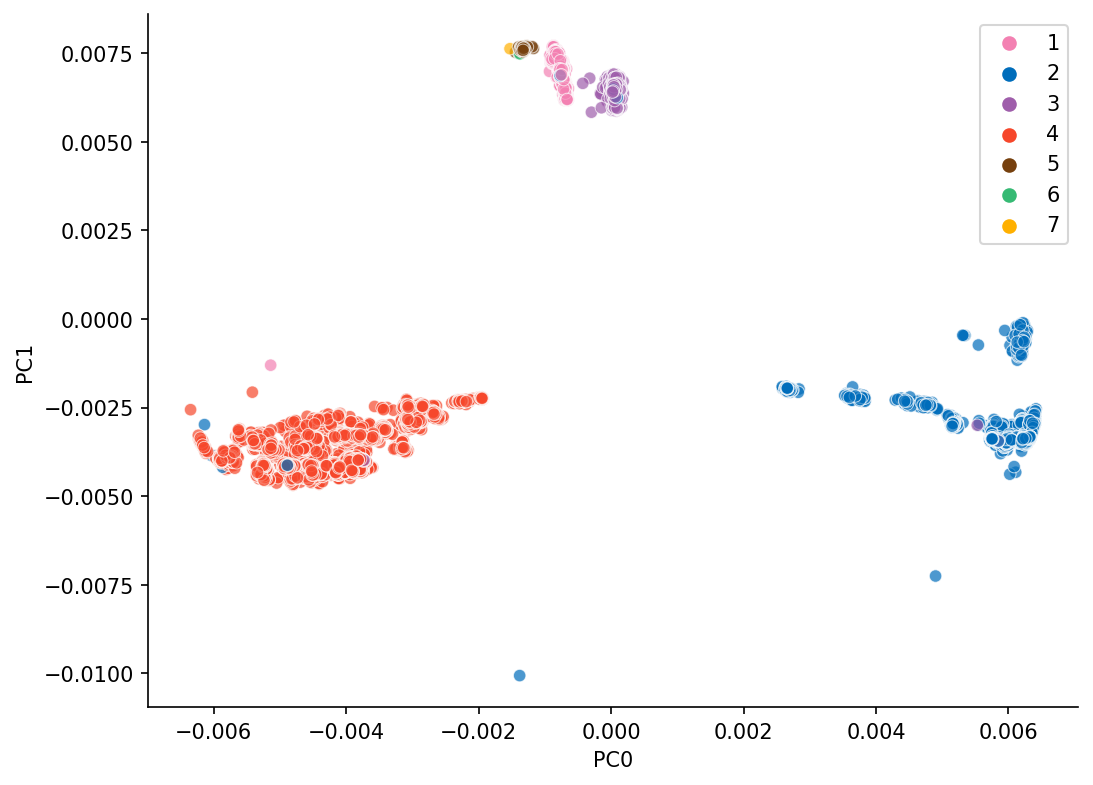

In [105]:
plot_PCA_colored_by_lineage(single_lineages, ['1', '2', '3', '4', '5', '6', '7'], color_col="Lineage", color_dict=LinToColor_Dict, pc_x='PC0', pc_y='PC1', saveFig='PC0_PC1_single_lineages.png')

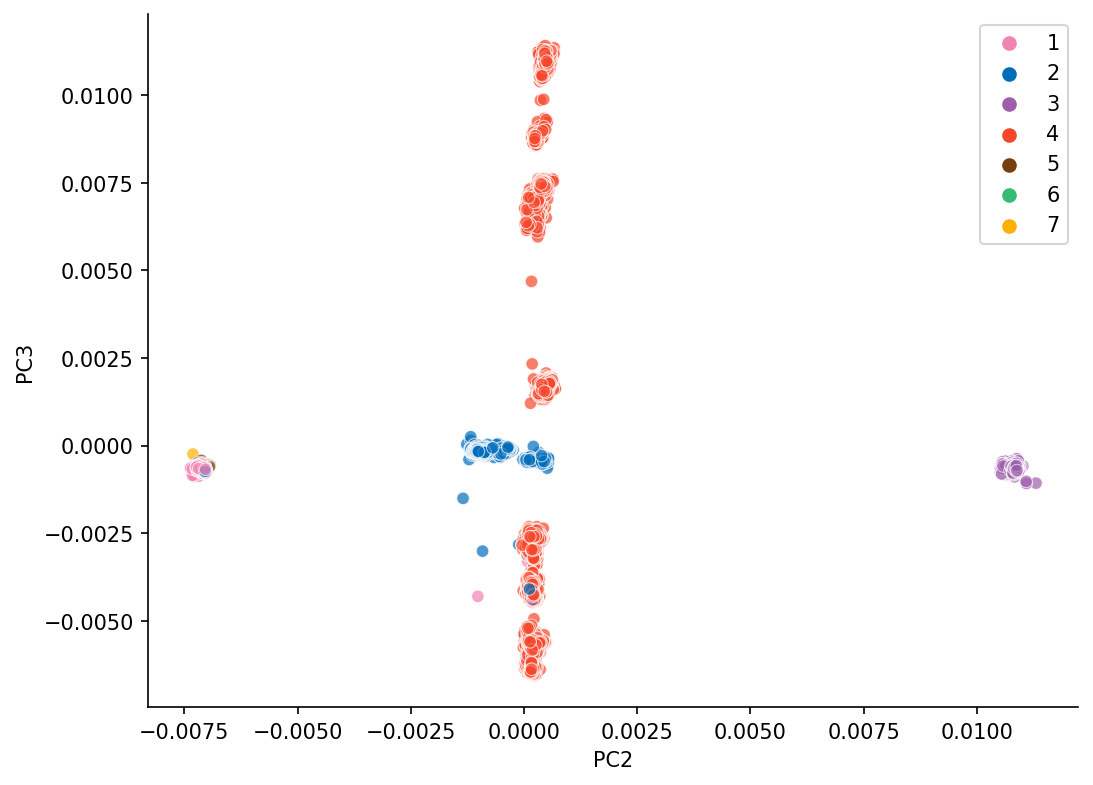

In [6]:
plot_PCA_colored_by_lineage(single_lineages, ['1', '2', '3', '4', '5', '6', '7'], color_col="Lineage", color_dict=LinToColor_Dict, pc_x='PC2', pc_y='PC3', saveFig='PC2_PC3_single_lineages.png')

In [12]:
# plot_PCA_colored_by_lineage(single_lineages, ['2'], color_col="Coll2014", color_dict=None, pc_x='PC0', pc_y='PC1', saveFig='PC0_PC1_single_lineages_L2.2.1.png')

# 4. Comparison of SOLO V2 and Regression Results

In [324]:
solo_results = pd.read_excel("../data/SOLO primary_STATA_ver18Feb2023.xlsx", sheet_name=None)

if len(solo_results) == 1:
    solo_results = solo_results[list(solo_results.keys())[0]]
    
print(len(solo_results.drug.unique()))

16


In [331]:
def make_solo_regression_comparison_table(drug, solo_results, tiers_lst):
    
    # read in Excel file
    if drug == "Pretomanid":
        results = pd.read_excel(f"../results/BINARY/{drug}.xlsx", sheet_name=["Model_11"])
    else:
        if tiers_lst == ["1"]:
            results = pd.read_excel(f"../results/BINARY/{drug}.xlsx", sheet_name=["Model_3", "Model_11"])
        elif tiers_lst == ["2"]:
            results = pd.read_excel(f"../results/BINARY/{drug}.xlsx", sheet_name=["Model_7", "Model_15"])
        elif len(tiers_lst) == 2:
            results = pd.read_excel(f"../results/BINARY/{drug}.xlsx", sheet_name=["Model_3", "Model_7", "Model_11", "Model_15"])

    # combine results across different models, keeping the first appearance of a mutation
    df = [results[model_name].loc[~pd.isnull(results[model_name]["Odds_Ratio"])] for model_name in list(results.keys())]
    df = pd.concat(df).drop_duplicates("mutation", keep="first")
    
    # combine with solo results
    df = solo_results.query("drug==@drug").merge(df[["mutation", "regression_confidence"]], 
                                                 left_on="variant", right_on="mutation", how="inner"
                                                )
    
    # create a mapping between the categories of the SOLO algorithm and regression so that they can be compared
    confidence_mapping = {'1) Assoc w R': "Assoc w R - strict",
                           "2) Assoc w R - interim": "Assoc w R",
                           "3) Uncertain significance": "Uncertain",
                           "4) Not assoc w R - interim": "Assoc w S",
                           '5) Not assoc w R': "Assoc w S - strict"
                          }

    confidence_mapping_rev = {val: key for (key, val) in confidence_mapping.items()}

    # all pairs (exhaustive list, so 5 x 5)
    pairs = list(itertools.product(confidence_mapping_rev.values(), confidence_mapping_rev.values()))

    # neutral mutations are in the 5) Not assoc w R category because they pass the Num_Isolates ≥ 5 threshold
    confidence_mapping_rev["Neutral"] = "5) Not assoc w R"
    
    # add new column denoting the gradings of the regression model, if they were transformed to the list they use
    df["Regression_Confidence_Grading"] = df["regression_confidence"].map(confidence_mapping_rev)
    
    # get counts of mutations across the groups
    counts_df = pd.DataFrame(df[["Initial_Confidence_Grading", "Regression_Confidence_Grading"]].value_counts()).reset_index().rename(columns={0:"Count"})
    
    # for pairs that are 0, they won't appear in the above dataframe, so manually add them with Count = 0
    for (a, b) in pairs:

        if len(counts_df.query("Initial_Confidence_Grading==@a & Regression_Confidence_Grading==@b")) == 0:
            counts_df = pd.concat([counts_df, pd.DataFrame({"Initial_Confidence_Grading": a, 
                                                            "Regression_Confidence_Grading": b,
                                                            "Count": 0
                                                           }, index=[0])])

    counts_df = counts_df.reset_index(drop=True)
    assert len(counts_df) == len(pairs)
    
    # return both the dataframe of mutation and the summary counts dataframe 
    return df, counts_df.pivot(index="Regression_Confidence_Grading", columns="Initial_Confidence_Grading", values="Count").fillna(0).astype(int)

In [334]:
drug = "Rifampicin"
df_rif, counts_rif = make_solo_regression_comparison_table(drug, solo_results, ["1"])
counts_rif

Initial_Confidence_Grading,1) Assoc w R,2) Assoc w R - interim,3) Uncertain significance,4) Not assoc w R - interim,5) Not assoc w R
Regression_Confidence_Grading,,,,,
1) Assoc w R,24,0,15,0,0
2) Assoc w R - interim,0,0,98,0,0
3) Uncertain significance,0,0,776,1,2
4) Not assoc w R - interim,0,0,18,0,5
5) Not assoc w R,0,0,4,0,1


In [338]:
df_rif.query("Initial_Confidence_Grading=='4) Not assoc w R - interim'")

,drug,variant,Initial_Confidence_Grading,mutation,regression_confidence,Regression_Confidence_Grading
385,Rifampicin,rpoB_p.Glu250Gly,4) Not assoc w R - interim,rpoB_p.Glu250Gly,Uncertain,3) Uncertain significance


In [332]:
drug = "Rifampicin"
df_rif, counts_rif = make_solo_regression_comparison_table(drug, solo_results, ["2"])
counts_rif

Initial_Confidence_Grading,1) Assoc w R,2) Assoc w R - interim,3) Uncertain significance,4) Not assoc w R - interim,5) Not assoc w R
Regression_Confidence_Grading,,,,,
1) Assoc w R,0,0,0,0,1
2) Assoc w R - interim,0,0,119,0,0
3) Uncertain significance,0,0,3214,0,30
4) Not assoc w R - interim,0,0,34,0,9
5) Not assoc w R,0,0,14,1,4


In [29]:
drug = "Rifampicin"
df_rif, counts_rif = make_solo_regression_comparison_table(drug, solo_results, ["1", "2"])
counts_rif

Initial_Confidence_Grading,1) Assoc w R,2) Assoc w R - interim,3) Uncertain significance,4) Not assoc w R - interim,5) Not assoc w R
Regression_Confidence_Grading,,,,,
1) Assoc w R,24,0,15,0,1
2) Assoc w R - interim,0,0,217,0,0
3) Uncertain significance,0,0,3990,1,32
4) Not assoc w R - interim,0,0,52,0,14
5) Not assoc w R,0,0,18,1,5


In [341]:
drug = "Bedaquiline"
df_bdq, counts_bdq = make_solo_regression_comparison_table(drug, solo_results, ["1", "2"])

In [342]:
counts_bdq

Initial_Confidence_Grading,1) Assoc w R,2) Assoc w R - interim,3) Uncertain significance,4) Not assoc w R - interim,5) Not assoc w R
Regression_Confidence_Grading,,,,,
1) Assoc w R,18,0,3,1,0
2) Assoc w R - interim,5,0,118,1,0
3) Uncertain significance,0,0,863,2,0
4) Not assoc w R - interim,0,0,14,1,0
5) Not assoc w R,0,0,0,0,1


In [348]:
drug = "Levofloxacin"
tier1_LEVO, tier1_LEVO_summary = make_solo_regression_comparison_table(drug, solo_results, ["1"])

In [357]:
tier1_LEVO_summary

Initial_Confidence_Grading,1) Assoc w R,2) Assoc w R - interim,3) Uncertain significance,4) Not assoc w R - interim,5) Not assoc w R
Regression_Confidence_Grading,,,,,
1) Assoc w R,13,0,7,0,0
2) Assoc w R - interim,0,0,38,1,1
3) Uncertain significance,0,0,716,0,4
4) Not assoc w R - interim,0,0,11,1,5
5) Not assoc w R,0,0,6,0,4


In [351]:
tier1_LEVO.query("Initial_Confidence_Grading == '3) Uncertain significance' & Regression_Confidence_Grading != '3) Uncertain significance'")

,drug,variant,Initial_Confidence_Grading,mutation,regression_confidence,Regression_Confidence_Grading
7,Levofloxacin,gyrA_c.-32C>T,3) Uncertain significance,gyrA_c.-32C>T,Assoc w R,2) Assoc w R - interim
16,Levofloxacin,gyrA_p.Ala288Asp,3) Uncertain significance,gyrA_p.Ala288Asp,Assoc w R,2) Assoc w R - interim
24,Levofloxacin,gyrA_p.Ala347Ser,3) Uncertain significance,gyrA_p.Ala347Ser,Assoc w R,2) Assoc w R - interim
52,Levofloxacin,gyrA_p.Ala626Val,3) Uncertain significance,gyrA_p.Ala626Val,Assoc w S,4) Not assoc w R - interim
56,Levofloxacin,gyrA_p.Ala676Val,3) Uncertain significance,gyrA_p.Ala676Val,Assoc w R,2) Assoc w R - interim
...,...,...,...,...,...,...
774,Levofloxacin,gyrB_p.Thr500Ala,3) Uncertain significance,gyrB_p.Thr500Ala,Assoc w R,2) Assoc w R - interim
775,Levofloxacin,gyrB_p.Thr500Asn,3) Uncertain significance,gyrB_p.Thr500Asn,Assoc w R - strict,1) Assoc w R
779,Levofloxacin,gyrB_p.Thr664Ile,3) Uncertain significance,gyrB_p.Thr664Ile,Assoc w R,2) Assoc w R - interim
794,Levofloxacin,gyrB_p.Val427Met,3) Uncertain significance,gyrB_p.Val427Met,Assoc w R,2) Assoc w R - interim


In [360]:
tier1_LEVO.query("Initial_Confidence_Grading == '3) Uncertain significance' & Regression_Confidence_Grading in ['1) Assoc w R', '5) Not assoc w R']").sort_values("regression_confidence")

,drug,variant,Initial_Confidence_Grading,mutation,regression_confidence,Regression_Confidence_Grading
267,Levofloxacin,gyrA_p.Gly88Ala,3) Uncertain significance,gyrA_p.Gly88Ala,Assoc w R - strict,1) Assoc w R
280,Levofloxacin,gyrA_p.His70Arg,3) Uncertain significance,gyrA_p.His70Arg,Assoc w R - strict,1) Assoc w R
339,Levofloxacin,gyrA_p.Lys636Thr,3) Uncertain significance,gyrA_p.Lys636Thr,Assoc w R - strict,1) Assoc w R
529,Levofloxacin,gyrB_p.Ala504Val,3) Uncertain significance,gyrB_p.Ala504Val,Assoc w R - strict,1) Assoc w R
551,Levofloxacin,gyrB_p.Arg446Cys,3) Uncertain significance,gyrB_p.Arg446Cys,Assoc w R - strict,1) Assoc w R
571,Levofloxacin,gyrB_p.Asn499Thr,3) Uncertain significance,gyrB_p.Asn499Thr,Assoc w R - strict,1) Assoc w R
775,Levofloxacin,gyrB_p.Thr500Asn,3) Uncertain significance,gyrB_p.Thr500Asn,Assoc w R - strict,1) Assoc w R
136,Levofloxacin,gyrA_p.Asp293Tyr,3) Uncertain significance,gyrA_p.Asp293Tyr,Assoc w S - strict,5) Not assoc w R
104,Levofloxacin,gyrA_p.Arg578Gln,3) Uncertain significance,gyrA_p.Arg578Gln,Neutral,5) Not assoc w R
415,Levofloxacin,gyrA_p.Thr572Asn,3) Uncertain significance,gyrA_p.Thr572Asn,Neutral,5) Not assoc w R


In [ ]:
tier1_LEVO.query("Initial_Confidence_Grading == ''")

In [343]:
drug_gene_mapping = pd.read_csv("../data/drug_gene_mapping.csv")

In [345]:
drug_gene_mapping.query("Drug=='Levofloxacin'")

,Drug,Gene,Tier
76,Levofloxacin,Rv1129c,2
77,Levofloxacin,Rv2752c,2
78,Levofloxacin,Rv2477c,2
79,Levofloxacin,glpK,2
80,Levofloxacin,gyrB,1
81,Levofloxacin,gyrA,1


# 5. INH Compensatory and Neutral Controls

In [279]:
compens_lst = ['c.-47_-46insT', 'c.-48G>A', 'c.-51G>A', 'c.-81C>T', 'c.-76T>A', 'c.-57C>T', 'c.-52C>T', 'c.-52C>A', 'c.-88_-87insAT', 'c.-77T>G', 'c.-72C>T', 'c.-54C>T', 'c.-74G>A', ]
compens_lst = ["ahpC_" + val for val in compens_lst]

# 'c.-42T>C' not in dataset, but 'c.-42T>G' is
neutral_lst = ['c.-88G>A', 'c.-46G>A', 'c.-84T>C', 'c.-42T>C', 'c.-42T>G', 'c.-88G>A', 'c.-10G>A', 'c.33G>A']
neutral_lst = ["ahpC_" + val for val in neutral_lst]

print(len(np.unique(compens_lst)), len(np.unique(neutral_lst)))

# INH_genos = pd.read_csv(os.path.join(analysis_dir, "Isoniazid/genos_1.csv.gz"), compression="gzip", usecols=["resolved_symbol", "variant_category"]).drop_duplicates() 
# INH_genos["mutation"] = INH_genos["resolved_symbol"] + "_" + INH_genos["variant_category"]
INH_results = pd.read_excel("../results/BINARY/Isoniazid.xlsx", sheet_name=None)

13 7


In [281]:
# INH_genos.query("resolved_symbol=='ahpC' & mutation.str.contains('|'.join(['-84', '-42']))")

In [27]:
print(INH_genos.query("mutation in @compens_lst").shape)
INH_genos.query("mutation in @compens_lst")

(13, 3)


,resolved_symbol,variant_category,mutation
108979348,ahpC,c.-57C>T,ahpC_c.-57C>T
109709938,ahpC,c.-52C>T,ahpC_c.-52C>T
110732764,ahpC,c.-52C>A,ahpC_c.-52C>A
113801242,ahpC,c.-77T>G,ahpC_c.-77T>G
114677950,ahpC,c.-51G>A,ahpC_c.-51G>A
115700776,ahpC,c.-76T>A,ahpC_c.-76T>A
115822868,ahpC,c.-54C>T,ahpC_c.-54C>T
116531633,ahpC,c.-88_-87insAT,ahpC_c.-88_-87insAT
116610172,ahpC,c.-47_-46insT,ahpC_c.-47_-46insT
118168764,ahpC,c.-74G>A,ahpC_c.-74G>A


In [28]:
print(INH_genos.query("mutation in @neutral_lst").shape)
INH_genos.query("mutation in @neutral_lst")

(3, 3)


,resolved_symbol,variant_category,mutation
109275867,ahpC,c.-88G>A,ahpC_c.-88G>A
119259169,ahpC,c.-84T>C,ahpC_c.-84T>C
121383360,ahpC,c.-10G>A,ahpC_c.-10G>A


In [289]:
solo_results.query("drug=='Isoniazid' & variant in @compens_lst")

,drug,variant,Initial_Confidence_Grading
21566,Isoniazid,ahpC_c.-47_-46insT,3) Uncertain significance
21567,Isoniazid,ahpC_c.-48G>A,3) Uncertain significance
21568,Isoniazid,ahpC_c.-51G>A,3) Uncertain significance
21569,Isoniazid,ahpC_c.-52C>A,3) Uncertain significance
21571,Isoniazid,ahpC_c.-52C>T,3) Uncertain significance
21574,Isoniazid,ahpC_c.-54C>T,3) Uncertain significance
21577,Isoniazid,ahpC_c.-57C>T,3) Uncertain significance
21579,Isoniazid,ahpC_c.-72C>T,3) Uncertain significance
21580,Isoniazid,ahpC_c.-74G>A,3) Uncertain significance
21583,Isoniazid,ahpC_c.-76T>A,3) Uncertain significance


In [42]:
INH_results["Model_3"].query("mutation.isin(@neutral_lst)")[['mutation', 'PPV_LB', 'confidence_V1',
       'Odds_Ratio', 'BH_pval', 'neutral_BH_pval', 'Mut_R', 'Mut_S', 'NoMut_S', 'NoMut_R', "regression_confidence"]]

,mutation,PPV_LB,confidence_V1,Odds_Ratio,BH_pval,neutral_BH_pval,Mut_R,Mut_S,NoMut_S,NoMut_R,regression_confidence
668,ahpC_c.-42T>G,0.025000,3) Uncertain significance,1.007639,0.562238,0.000000,1.0,0.0,21433.0,13380.0,Uncertain
1171,ahpC_c.-84T>C,0.000000,3) Uncertain significance,0.985015,0.562238,0.466840,0.0,2.0,21431.0,13381.0,Uncertain
1210,ahpC_c.-10G>A,0.000000,NaN,0.983347,0.562238,0.482722,0.0,2.0,21431.0,13381.0,Uncertain
1334,ahpC_c.-88G>A,0.221026,5) Not assoc w R,0.952190,0.288857,0.000000,982.0,3219.0,18214.0,12399.0,Neutral


In [36]:
INH_results["Model_3"].query("mutation.isin(@compens_lst)")[['mutation', 'PPV_LB', 'confidence_V1',
       'Odds_Ratio', 'BH_pval',
       'LRT_BH_pval', 'Mut_R', 'Mut_S', 'NoMut_S', 'NoMut_R', "regression_confidence"]]

,mutation,PPV_LB,confidence_V1,Odds_Ratio,BH_pval,LRT_BH_pval,Mut_R,Mut_S,NoMut_S,NoMut_R,regression_confidence
11,ahpC_c.-48G>A,0.884434,3) Uncertain significance,1.177554,0.000000,0.001040,114.0,7.0,21426.0,13267.0,Assoc w R - strict
12,ahpC_c.-57C>T,0.846732,3) Uncertain significance,1.172843,0.000000,0.000002,33.0,1.0,21432.0,13348.0,Assoc w R - strict
15,ahpC_c.-76T>A,0.823533,3) Uncertain significance,1.137640,0.000000,0.000036,19.0,0.0,21433.0,13362.0,Assoc w R - strict
17,ahpC_c.-52C>T,0.768474,3) Uncertain significance,1.133538,0.000000,0.000964,56.0,8.0,21425.0,13325.0,Assoc w R - strict
20,ahpC_c.-54C>T,0.757102,3) Uncertain significance,1.122787,0.000000,0.036705,25.0,2.0,21431.0,13356.0,Assoc w R - strict
32,ahpC_c.-81C>T,0.732604,3) Uncertain significance,1.079631,0.000000,0.233376,43.0,7.0,21426.0,13338.0,Assoc w R
40,ahpC_c.-52C>A,0.803227,3) Uncertain significance,1.071485,0.000000,0.385443,32.0,2.0,21431.0,13349.0,Assoc w R
53,ahpC_c.-47_-46insT,0.897182,3) Uncertain significance,1.063391,0.000000,0.988430,34.0,0.0,21433.0,13347.0,Assoc w R
73,ahpC_c.-51G>A,0.635816,3) Uncertain significance,1.054542,0.005049,1.000000,43.0,13.0,21420.0,13338.0,Assoc w R
133,ahpC_c.-72C>T,0.580934,3) Uncertain significance,1.044559,0.005049,0.568587,17.0,4.0,21429.0,13364.0,Assoc w R


# 6. QQ Plots: Plot the Computed p-values vs. the Null Distribution of p-values

## Compare QQ Plot between Model + PCs and Model - PCs

In [25]:
def get_pvals_no_PCA(drug, drug_WHO_abbr, model_matrix_path, binary=True, num_bootstrap=1000, alpha=0.05):
    
    if binary:
        folder = "BINARY"
        df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv"))
    else:
        folder = "MIC"
        df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_mic.csv"))
        df_phenos = process_multiple_MICs(df_phenos)

    model_matrix = pd.read_pickle(os.path.join(analysis_dir, drug, folder, model_matrix_path, "model_matrix.pkl"))
    print(f"Original matrix: {model_matrix.shape}")

    df_phenos = df_phenos.set_index("sample_id")
    df_phenos = df_phenos.loc[model_matrix.index]

    # check that the sample ordering is the same in the genotype and phenotype matrices
    assert sum(model_matrix.index != df_phenos.index) == 0
    X = model_matrix.values

    # scale inputs
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # binary vs. quant (MIC) phenotypes
    if binary:
        y = df_phenos["phenotype"].values
        assert len(np.unique(y)) == 2
    else:
        y = np.log2(df_phenos["mic_value"].values)

    if len(y) != X.shape[0]:
        raise ValueError(f"Shapes of model inputs {X.shape} and outputs {len(y)} are incompatible")
    print(f"{X.shape[0]} samples and {X.shape[1]} variables in the model")
    
    if binary:
        model = LogisticRegressionCV(Cs=np.logspace(-6, 6, 13), 
                                     cv=5,
                                     penalty='l2',
                                     max_iter=10000, 
                                     multi_class='ovr',
                                     scoring='neg_log_loss',
                                     class_weight='balanced'
                                    )


    else:
        model = RidgeCV(alphas=np.logspace(-6, 6, 13),
                        cv=5,
                        scoring='neg_root_mean_squared_error'
                       )
    model.fit(X, y)

    coef_df = pd.DataFrame({"mutation": model_matrix.columns, "coef": np.squeeze(model.coef_)})
    
    if num_bootstrap == 0:
        raise ValueError("Number of replicates must be positive for the permutation test!")
    else:
        print(f"Performing permutation test with {num_bootstrap} replicates")
        permute_df = perform_permutation_test(model, X, y, num_bootstrap, binary=binary)
        permute_df.columns = model_matrix.columns
        return get_coef_and_confidence_intervals(alpha, binary, who_variants_combined, drug_WHO_abbr, coef_df, permute_df=permute_df, bootstrap_df=None)        

In [26]:
def read_in_stuff(drug, tiers_lst, phenos, eigenvec_df=eigenvec_df):

    # no_PCA = pd.read_csv("../MXF_no_PCA.csv")

    model_matrix = pd.read_pickle(os.path.join(analysis_dir, drug, f"BINARY/tiers={'+'.join(tiers_lst)}/phenos={phenos}/dropAF_noSyn_unpooled/model_matrix.pkl"))
    model_matrix = model_matrix.merge(eigenvec_df, left_index=True, right_index=True)

    # MXF_with_PCA = pd.read_excel("../results/BINARY/Moxifloxacin.xlsx", sheet_name="Model_3")
    # MXF_with_PCA = MXF_with_PCA.loc[~pd.isnull(MXF_with_PCA["Odds_Ratio"])]
    with_PCA = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers={'+'.join(tiers_lst)}/phenos={phenos}/dropAF_noSyn_unpooled/model_analysis.csv"))
    df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv"))

    model_matrix = model_matrix.merge(lineages.set_index("sample_id")[["Coll2014"]], left_index=True, right_index=True)
    model_matrix["Lineage"] = model_matrix["Coll2014"].str[0]
    model_matrix = model_matrix.merge(df_phenos.set_index("sample_id")[["phenotype"]], left_index=True, right_index=True)
    
    # print(MXF_no_PCA.shape, with_PCA.shape)
    print(with_PCA.shape)
    
    return with_PCA, model_matrix

In [24]:
# tiers_lst = ["1"]
# phenos = "ALL"

# with_PCA, model_matrix = read_in_stuff("Bedaquiline", tiers_lst, phenos)
# no_PCA = pd.read_csv(f"../BDQ_{phenos}_tiers={'+'.join(tiers_lst)}_no_PCA.csv")
# print(no_PCA.shape)

# # increment the p-values that are 0 so that you can take the log of them
# no_PCA_pvals = no_PCA["pval"].values
# second_smallest = np.sort(np.unique(no_PCA_pvals))[1] / 10
# no_PCA_pvals += second_smallest

# with_PCA_pvals = with_PCA.query("~mutation.str.contains('PC')")["pval"].values
# second_smallest = np.sort(np.unique(with_PCA_pvals))[1] / 10
# with_PCA_pvals += second_smallest

# assert len(no_PCA_pvals) == len(with_PCA_pvals)

In [ ]:
def one_sample_pvalue_qqplot(data, label, saveName=None):
    
    data = -np.log10(data)        
    quantiles = np.quantile(data, q=np.linspace(0, 1, len(data)))

    # from sklearn.preprocessing import MinMaxScaler
#     quantile_scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
#     quantiles = quantile_scaler.fit_transform(np.reshape(quantiles, (-1, 1)))
    
#     # quantiles of the uniform distribution (under the null hypothesis, p-values are uniformly distributed)
#     uniform_quantiles = np.quantile(np.random.uniform(low=0, high=1, size=len(data)), q=np.linspace(0, 1, len(data)))
    
    uniform_data = -np.log10(np.random.uniform(low=0, high=1, size=len(data)))
    uniform_quantiles = np.quantile(uniform_data, q=np.linspace(0, 1, len(uniform_data)))
    
    min_val = np.min([quantiles, uniform_quantiles])
    max_val = np.max([quantiles, uniform_quantiles])
    
    # Create QQ plot
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.scatter(uniform_quantiles, quantiles, alpha=0.5, s=25, linewidths=0.25, edgecolors='black')
    ax.set_xlabel("Uniform p-value Quantiles")
    ax.set_ylabel("Sample p-value Quantiles")
    ax.set_xlim(min_val*0.8, max_val*1.1)
    ax.set_ylim(min_val*0.8, max_val*1.1)
    ax.set_title(label)

    # Add 45-degree line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, linestyle='--', color='black', linewidth=1)

    # Show plot
    sns.despine()
    
    if saveName is not None:
        plt.savefig(saveName, dpi=350)
    else:
        plt.show()
    
    
    
def two_sample_pvalue_qqplot(data1, data2, xlabel, ylabel, title=None, saveName=None):
    
    data1 = -np.log10(data1)
    data2 = -np.log10(data2)
        
    quantiles1 = np.quantile(data1, q=np.linspace(0, 1, len(data1)))
    quantiles2 = np.quantile(data2, q=np.linspace(0, 1, len(data2)))
    
    # Create QQ plot
    fig, ax = plt.subplots(figsize=(5, 4))
    plt.title(title)
    ax.scatter(quantiles1, quantiles2, alpha=0.75, s=30, linewidths=0.25, edgecolors='black')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # ax.set_title('Two-Sample QQ Plot')

    # Add 45-degree line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, linestyle='--', color='black', linewidth=1)

    # Show plot
    sns.despine()
    
    if saveName is not None:
        plt.savefig(saveName, dpi=350)
    else:
        plt.show()

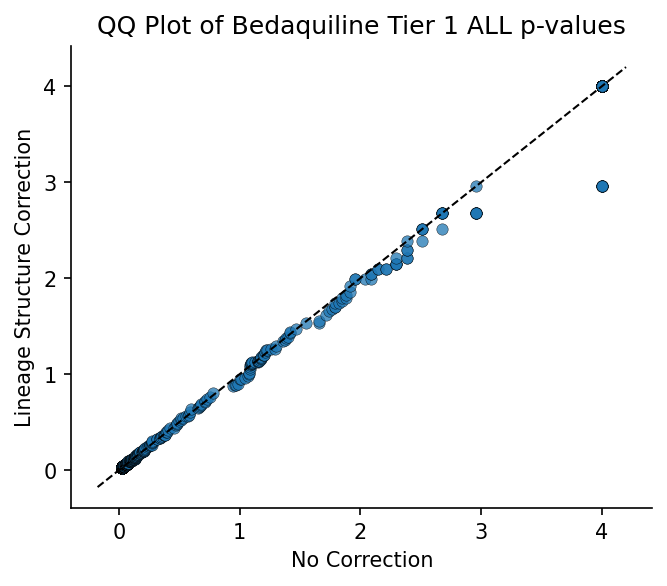

In [23]:
two_sample_pvalue_qqplot(no_PCA_pvals, 
                         with_PCA_pvals, 
                         xlabel="No Correction",
                         ylabel="Lineage Structure Correction", 
                         title="QQ Plot of Bedaquiline Tier 1 ALL p-values",
                         #saveName="BDQ_qqplot_tier1+2_ALL.png"
                        )

# 7. Model AUCs: Bedaquiline and Levofloxacin

<ul>
    <li>DROP vs. HET</li>
    <li>Tier 1 vs. Tier 1 + 2</li>
    <li>WHO vs. ALL</li>
</ul>


In [368]:
binary_model_paths = ["tiers=1/phenos=WHO/dropAF_noSyn_unpooled",
                       "tiers=1+2/phenos=WHO/dropAF_noSyn_unpooled",
                       "tiers=1/phenos=ALL/dropAF_noSyn_unpooled",
                       "tiers=1+2/phenos=ALL/dropAF_noSyn_unpooled"
                      ]

het_model_paths = ["tiers=1/phenos=WHO/encodeAF_noSyn_unpooled",
                       "tiers=1+2/phenos=WHO/encodeAF_noSyn_unpooled",
                       "tiers=1/phenos=ALL/dencodeAF_noSyn_unpooled",
                       "tiers=1+2/phenos=ALL/encodeAF_noSyn_unpooled"
                      ]

def single_drug_bar_chart(drug, model_paths_lst=model_paths, saveName=None):
    
    combined_df = []

    for path in model_paths_lst:
        
        fName = os.path.join(analysis_dir, drug, "BINARY", path, "model_stats_with_bootstrap.csv")
        
        if os.path.isfile(fName):
            
            df = pd.read_csv(fName, index_col=[0])
            if "ALL" in path:
                df["Phenos"] = "ALL"
            else:
                df["Phenos"] = "WHO"

            if "1+2" in path:
                df["Tiers"] = "1+2"
            else:
                df["Tiers"] = "1"

            combined_df.append(df)

    combined_df = pd.concat(combined_df, axis=0).reset_index(drop=True)
    combined_df = combined_df.melt(id_vars=["Tiers", "Phenos"])

    combined_df["Model"] = "Tiers " + combined_df["Tiers"] + ",\n" + combined_df["Phenos"] + " Phenos"

    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(data=combined_df.query("variable not in ['accuracy', 'balanced_acc']"),
                x="Model",
                y="value",
                hue="variable",
                palette=sns.color_palette("colorblind"),
                ax=ax
                )
    
    bar_scale = 0.8
    for patch in ax.patches:
        current_width = patch.get_width()
        patch.set_width(current_width * bar_scale)
        
    label_loc = 'edge'
    annot_format = '{:.2f}'
    ax.bar_label(ax.containers[0], fmt=annot_format, label_type=label_loc)
    ax.bar_label(ax.containers[1], fmt=annot_format, label_type=label_loc)
    ax.bar_label(ax.containers[2], fmt=annot_format, label_type=label_loc)

    plt.title(f"{drug} Models: Mutations Significant by Permutation Test\n")
    plt.ylabel("")
    sns.move_legend(ax, fontsize=8, title='', loc='upper right', #bbox_to_anchor=(1.12, 0.6)
                    ncol=len(combined_df["variable"].unique()), bbox_to_anchor=(0.7, -0.2)
                   )

    sns.despine()
    
    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName, bbox_inches="tight", dpi=400)
        
    return combined_df

In [371]:
# BDQ_het_stats = single_drug_bar_chart("Bedaquiline", 
#                                   model_paths_lst=het_model_paths
#                                   #saveName="BDQ_binary_models_summary.png"
#                                  )

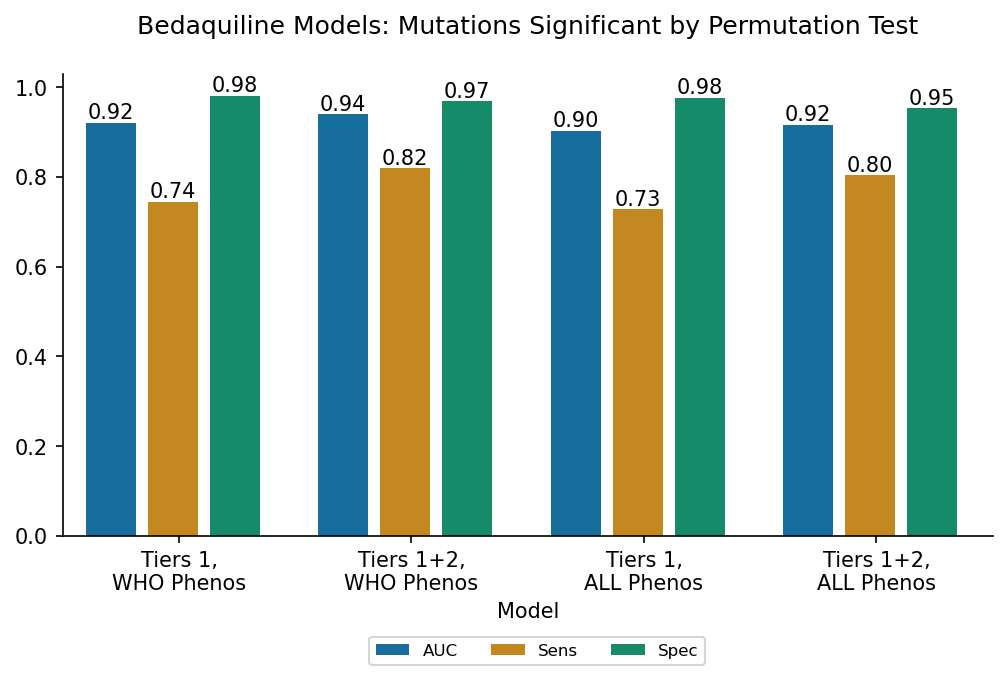

In [369]:
BDQ_stats = single_drug_bar_chart("Bedaquiline", 
                                  model_paths_lst=binary_model_paths,
                                  saveName="BDQ_binary_models_summary.png"
                                 )

For Levofloxacin, numbers of significant mutations:

<ul>
    <li>Tiers = 1, phenos = WHO: 63 mutations, 12,441 isolates</li>
    <li>Tiers = 1 + 2, phenos = WHO: 79 mutations, 12,440 isolates</li>
    <li>Tiers = 1, phenos = ALL: 82 mutations, 27,573 isolates </li>
    <li>Tiers = 1 + 2, phenos = ALL: 126 mutations, 27,551 isolates</li>
</ul>

NO HETS FOR LEV!

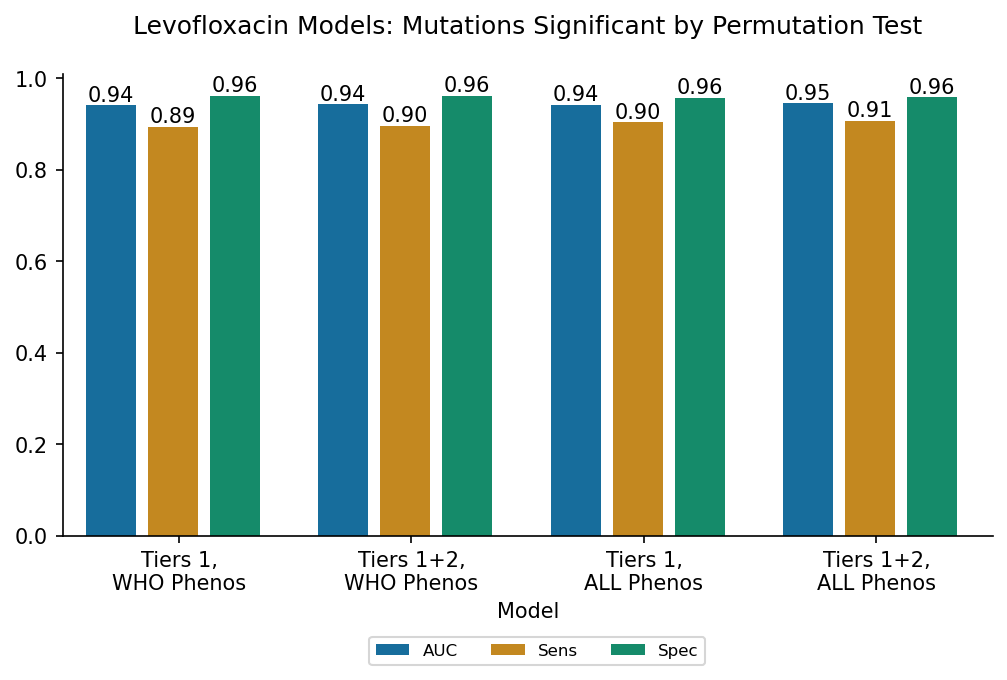

In [278]:
LEV_stats = single_drug_bar_chart("Levofloxacin",
                                  saveName="LEV_binary_models_summary.png"
                                 )